# Integrantes
- Aguilar Martínez Erick Yair
- Martínez Muñoz Alan Magno
- Mendoza Hernández Carlos Emiliano

# K-means y K-modes

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class KMeans():
    """
    A class to implement the K-Means clustering algorithm.
    
    Attributes
    ----------
    n_clusters : int
        The number of clusters to form.
    max_iter : int
        Maximum number of iterations of the K-Means algorithm for a single run.
    n_init : int
        Number of time the K-Means algorithm will be run with different centroid seeds.
    centroids : array-like, shape (n_clusters, n_features), optional
        Coordinates of cluster centers.
    
    Methods
    -------
    __generate_random_centroids(X_train):
        Generates random centroids within the range of the training data.
    
    fit(X_train):
        Computes K-Means clustering.
    
    predict(X):
        Predicts the closest cluster each sample in X belongs to.
    """
    def __init__(self,n_clusters,max_iter=200,n_init=25):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.n_init = n_init
    def __generate_random_centroids(self,X_train):
        mins = np.min(X_train,axis=0)
        maxs = np.max(X_train,axis=0)
        return np.array([
            np.random.uniform(mins,maxs)
            for _ in range(self.n_clusters)
        ])
    def fit(self, X_train):
        best_centroids = None
        min_distance_sum = np.inf

        for _ in range(self.n_init):
            labels = np.zeros(X_train.shape[0], dtype=np.int16)
            self.centroids = self.__generate_random_centroids(X_train)
            for _ in range(self.max_iter):
                distances = np.linalg.norm(X_train[:, np.newaxis] - self.centroids, axis=2)
                new_labels = np.argmin(distances, axis=1)
                v,_ = np.unique_counts(new_labels)

                new_centroids = np.array([
                    X_train[new_labels == k].mean(axis=0)
                    if k in v else self.centroids[k]
                    for k in range(self.n_clusters)
                ])

                self.centroids = new_centroids

                distance_sum = np.sum(np.min(distances, axis=1))

                if distance_sum < min_distance_sum:
                    min_distance_sum = distance_sum
                    best_centroids = self.centroids.copy()

                num_changes = np.sum(new_labels != labels)
                if num_changes == 0:
                    break
                labels = new_labels

        self.centroids = best_centroids
        return self.centroids
    def predict(self,X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

In [8]:
X_train = np.array([
    [1, 12.5],
    [3, 10.5],
    [3, 12.5],
    [3, 14.5],
    [3, 18],
    [5, 18],
    [5, 16],
    [5, 14.5],
    [5, 13],
    [6, 9],
    [8, 10],
    [9, 11],
    [8.5, 12],
    [7, 13.5],
    [8, 16],
    [0.5, 10.5]
])

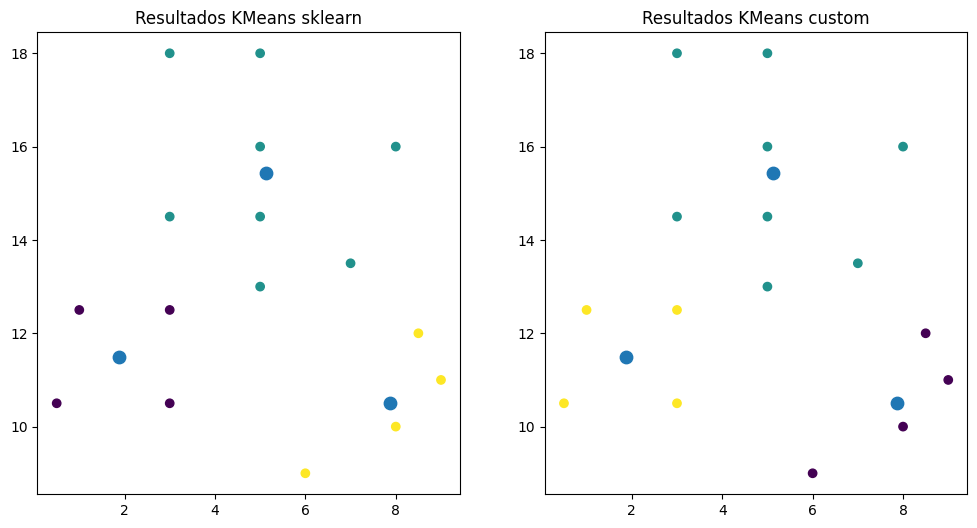

In [9]:
import sklearn.cluster as skc
km_custom = KMeans(n_clusters=3)
km_custom.fit(X_train)
labels_custom = km_custom.predict(X_train)
km_sklearn = skc.KMeans(n_clusters=3)
km_sklearn.fit(X_train)
labels_sk = km_sklearn.predict(X_train)
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(X_train[:,0],X_train[:,1],c=labels_sk)
ax[0].set_title('Resultados KMeans sklearn')
ax[0].scatter(km_sklearn.cluster_centers_[:,0],km_sklearn.cluster_centers_[:,1],s=80)
ax[1].set_title('Resultados KMeans custom')
ax[1].scatter(X_train[:,0],X_train[:,1],c=labels_custom)
ax[1].scatter(km_custom.centroids[:,0],km_custom.centroids[:,1],s=80)
plt.show()

In [15]:
class KModes():
    """
    A class to implement the K-Modes clustering algorithm, which is used for clustering categorical data.
    
    Attributes
    ----------
    n_clusters : int
        The number of clusters to form.
    max_iter : int
        Maximum number of iterations of the K-Modes algorithm for a single run.
    n_init : int
        Number of time the K-Modes algorithm will be run with different centroid seeds.
    centroids : array-like, shape (n_clusters, n_features), optional
        Coordinates of cluster centers.
    
    Methods
    -------
    __generate_random_centroids(X_train):
        Generates random centroids from the training data for each categorical feature.
    
    __distance(x1, x2):
        Computes the distance (Hamming distance) between two categorical points.
    
    __getLabels(X_train, centroids):
        Assigns a label (cluster) to each point in the training data based on the closest centroid.
    
    __getCentroid(cluster):
        Computes the new centroid for a given cluster by taking the mode of each feature.
    
    __fit(X_train):
        Runs the K-Modes algorithm for a single initialization.
    
    fit(X_train):
        Repeats the K-Modes algorithm for n_init initializations to find the best clustering result.
    """
    def __init__(self,n_clusters,max_iter=250,n_init=20):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.n_init = n_init
    def __generate_random_centroids(self,X_train):
        return np.array([
            np.array([
                np.random.choice(X_train[:,i]) for i in range(X_train.shape[1])
            ]) for _ in range(self.n_clusters)
        ])
    def __distance(self,x1,x2):
        return np.sum(x1!=x2,dtype=np.uint32)
    def __getLabels(self,X_train,centroids):
        labels = []
        for xi in X_train:
            d = []
            for centroid in centroids:
                d.append(
                    self.__distance(
                        xi,
                        centroid
                    )
                )
            labels.append(
                np.argmin(d)
            )
        return np.array(labels)
    def __getCentroid(self,cluster):
        centroid = []
        for col in range(cluster.shape[1]):
            v,c = np.unique_counts(cluster[:,col])
            centroid.append(
                v[np.argmax(c)]
            )
        return np.array(centroid)
    def __fit(self, X_train):
        best_centroids = None
        min_dist_sum = np.inf

        centroids = self.__generate_random_centroids(X_train)
        for _ in range(self.max_iter):
            labels = self.__getLabels(X_train, centroids)
            new_centroids = []
            for i in range(self.n_clusters):
                cluster = X_train[labels == i]
                if len(cluster) == 0:
                    new_centroids.append(centroids[i])
                else:
                    new_centroid = self.__getCentroid(cluster)
                    new_centroids.append(new_centroid)

            new_labels = self.__getLabels(X_train, new_centroids)
            dist_sum = 0
            for i in range(len(X_train)):
                dist_sum += self.__distance(X_train[i],new_centroids[new_labels[i]])

            if dist_sum < min_dist_sum:
                min_dist_sum = dist_sum
                best_centroids = new_centroids
            num_changes = np.sum(new_labels != labels)
            if num_changes == 0:
                break
            centroids = new_centroids
        return best_centroids,min_dist_sum
    def fit(self,X_train):
        min_distance_sum = np.inf
        for _ in range(self.n_init):
            bc,dist_sum = self.__fit(X_train)
            if dist_sum < min_distance_sum:
                self.centroids = bc

In [25]:
from kmodes.kmodes import KModes as KModesModule
x1 = ['rojo','grande','redondo']
x2 = ['azul','pequeño','cuadrado']
X_train = np.array([
    x1,x1,x1,x1,x1,
    x2,x2,x2,x2,x2,
])
km_modes_custom = KModes(n_clusters=2)
km_modes_custom.fit(X_train)
km_module = KModesModule(n_clusters=2)
km_module.fit(X_train)
# un poco de formato para que se vea mejor
c = []
for cent in km_modes_custom.centroids:
    c.append(
        [
            str(cent[i]) for i in range(cent.shape[0])
        ]
    )
print(c)
print(km_module.cluster_centroids_)

[['azul', 'pequeño', 'cuadrado'], ['rojo', 'grande', 'redondo']]
[['rojo' 'grande' 'redondo']
 ['azul' 'pequeño' 'cuadrado']]


## Ejemplo 1

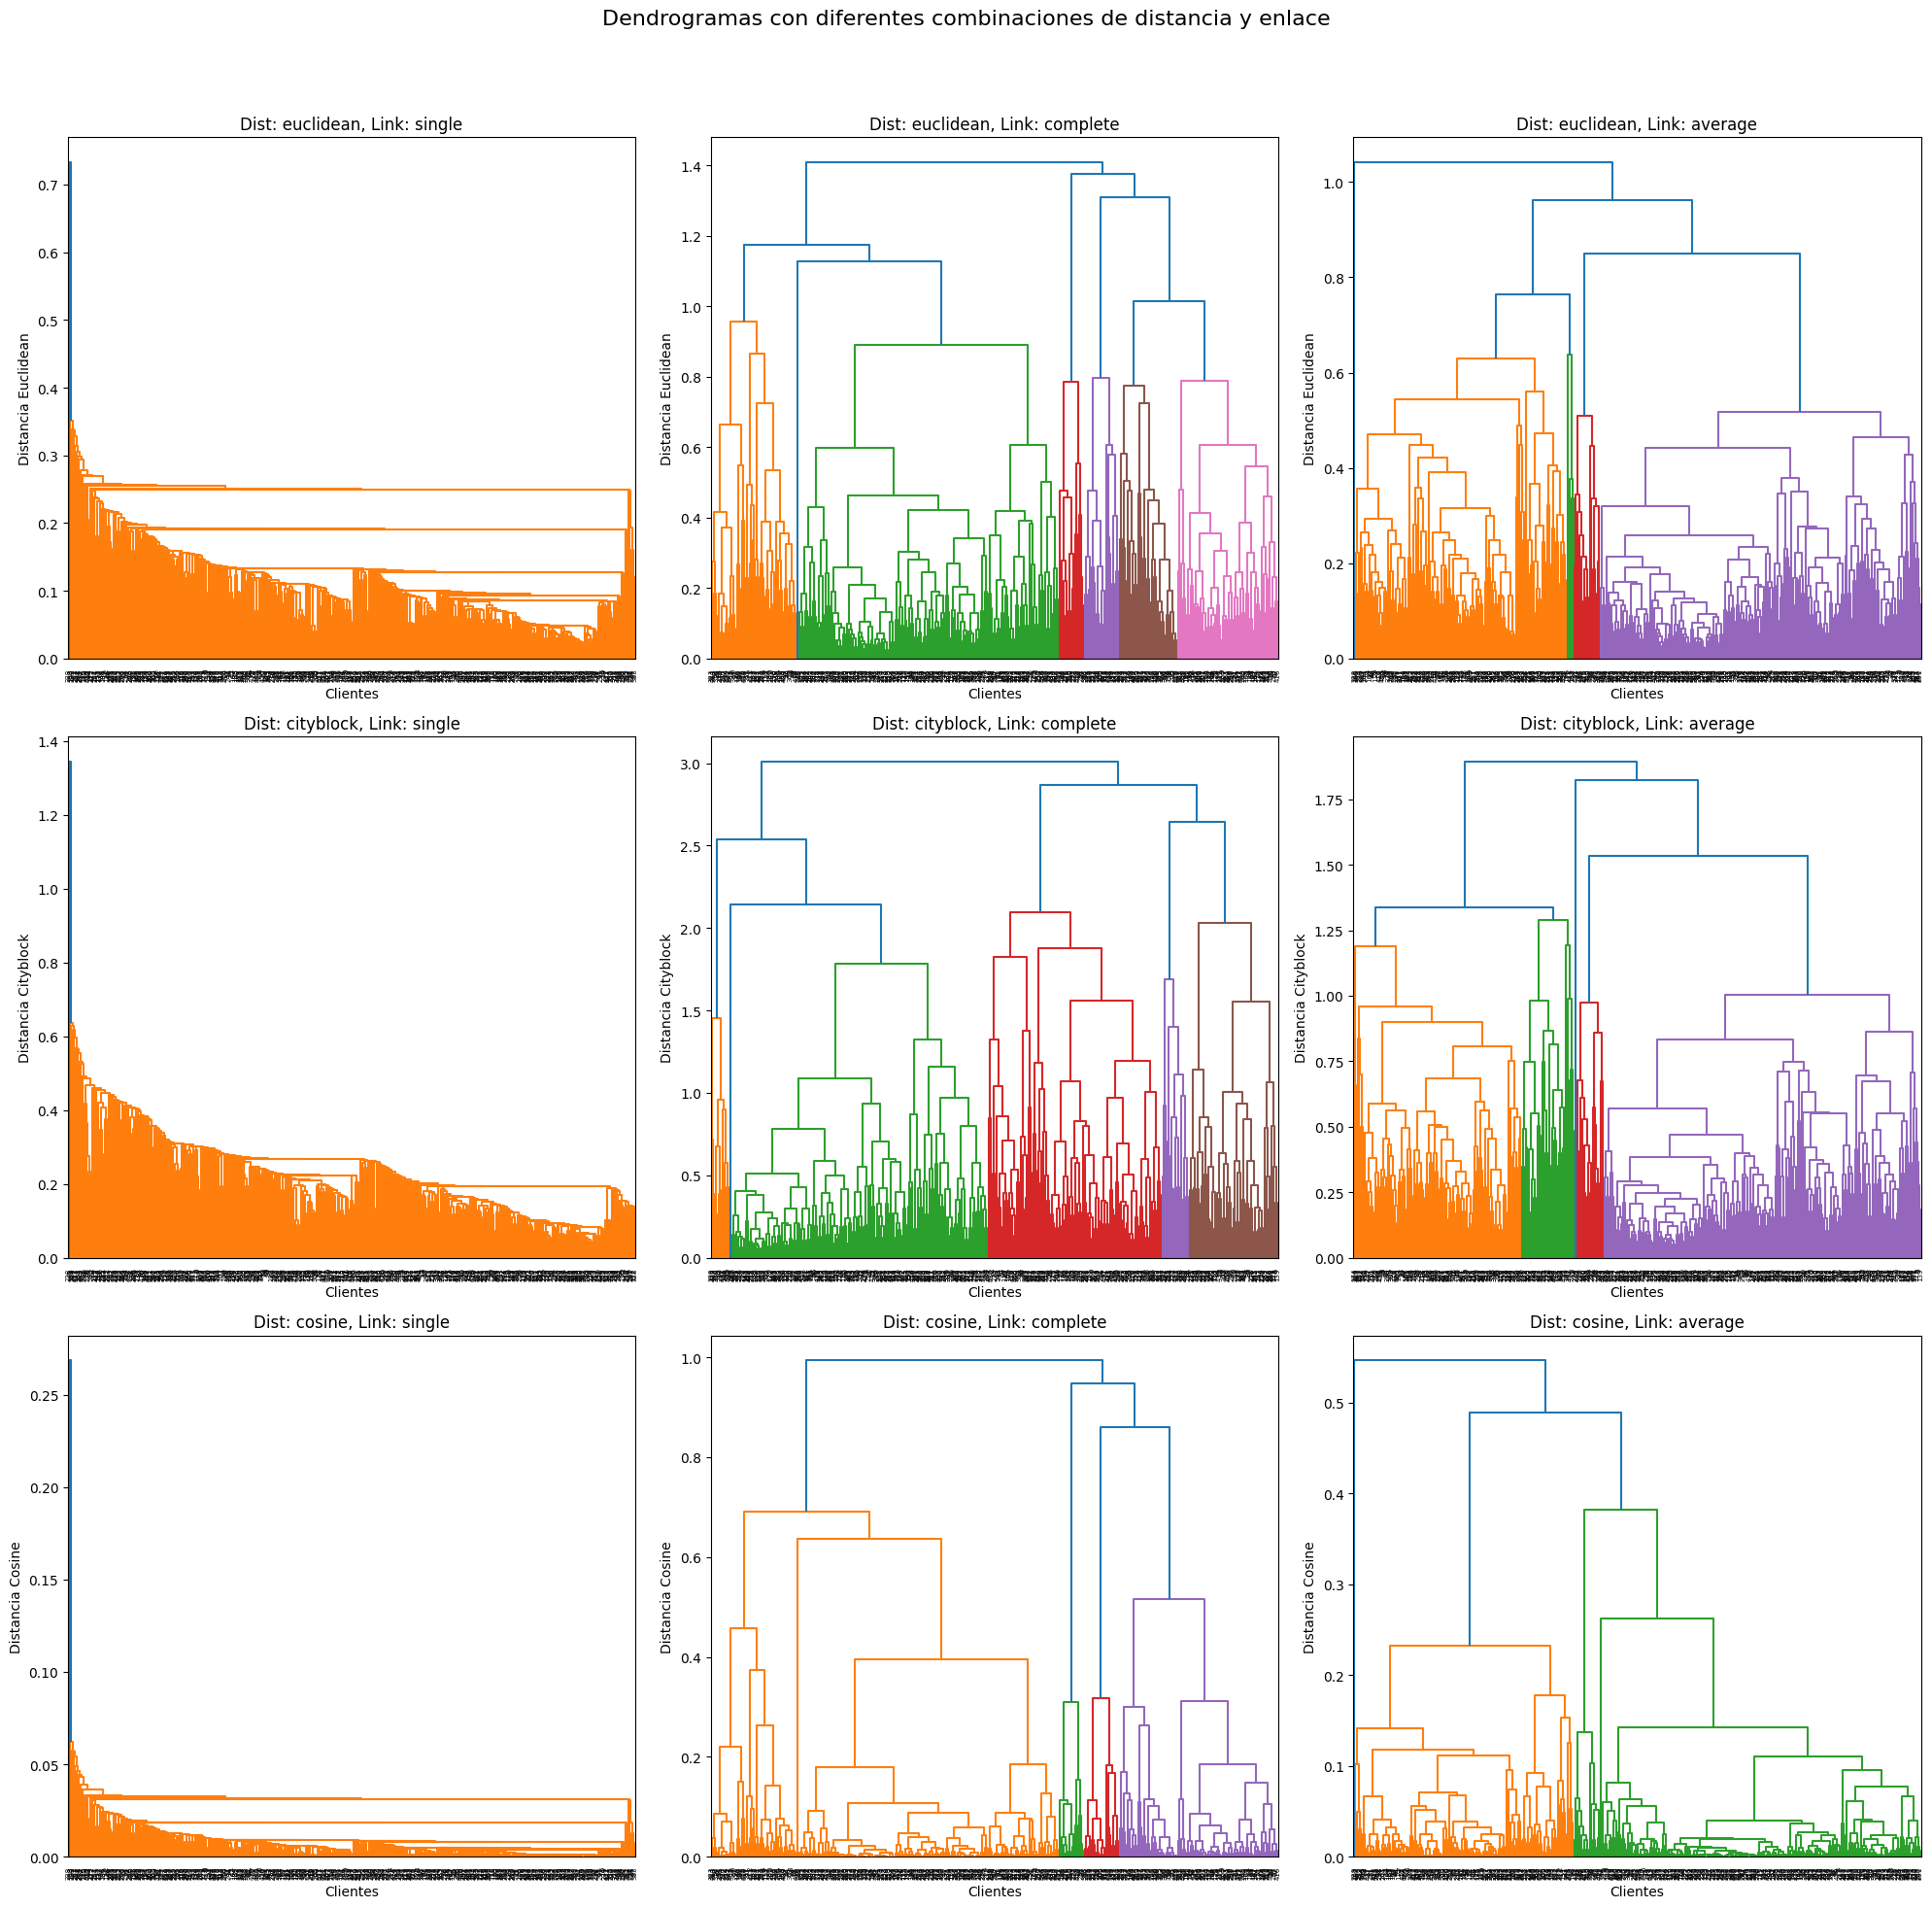

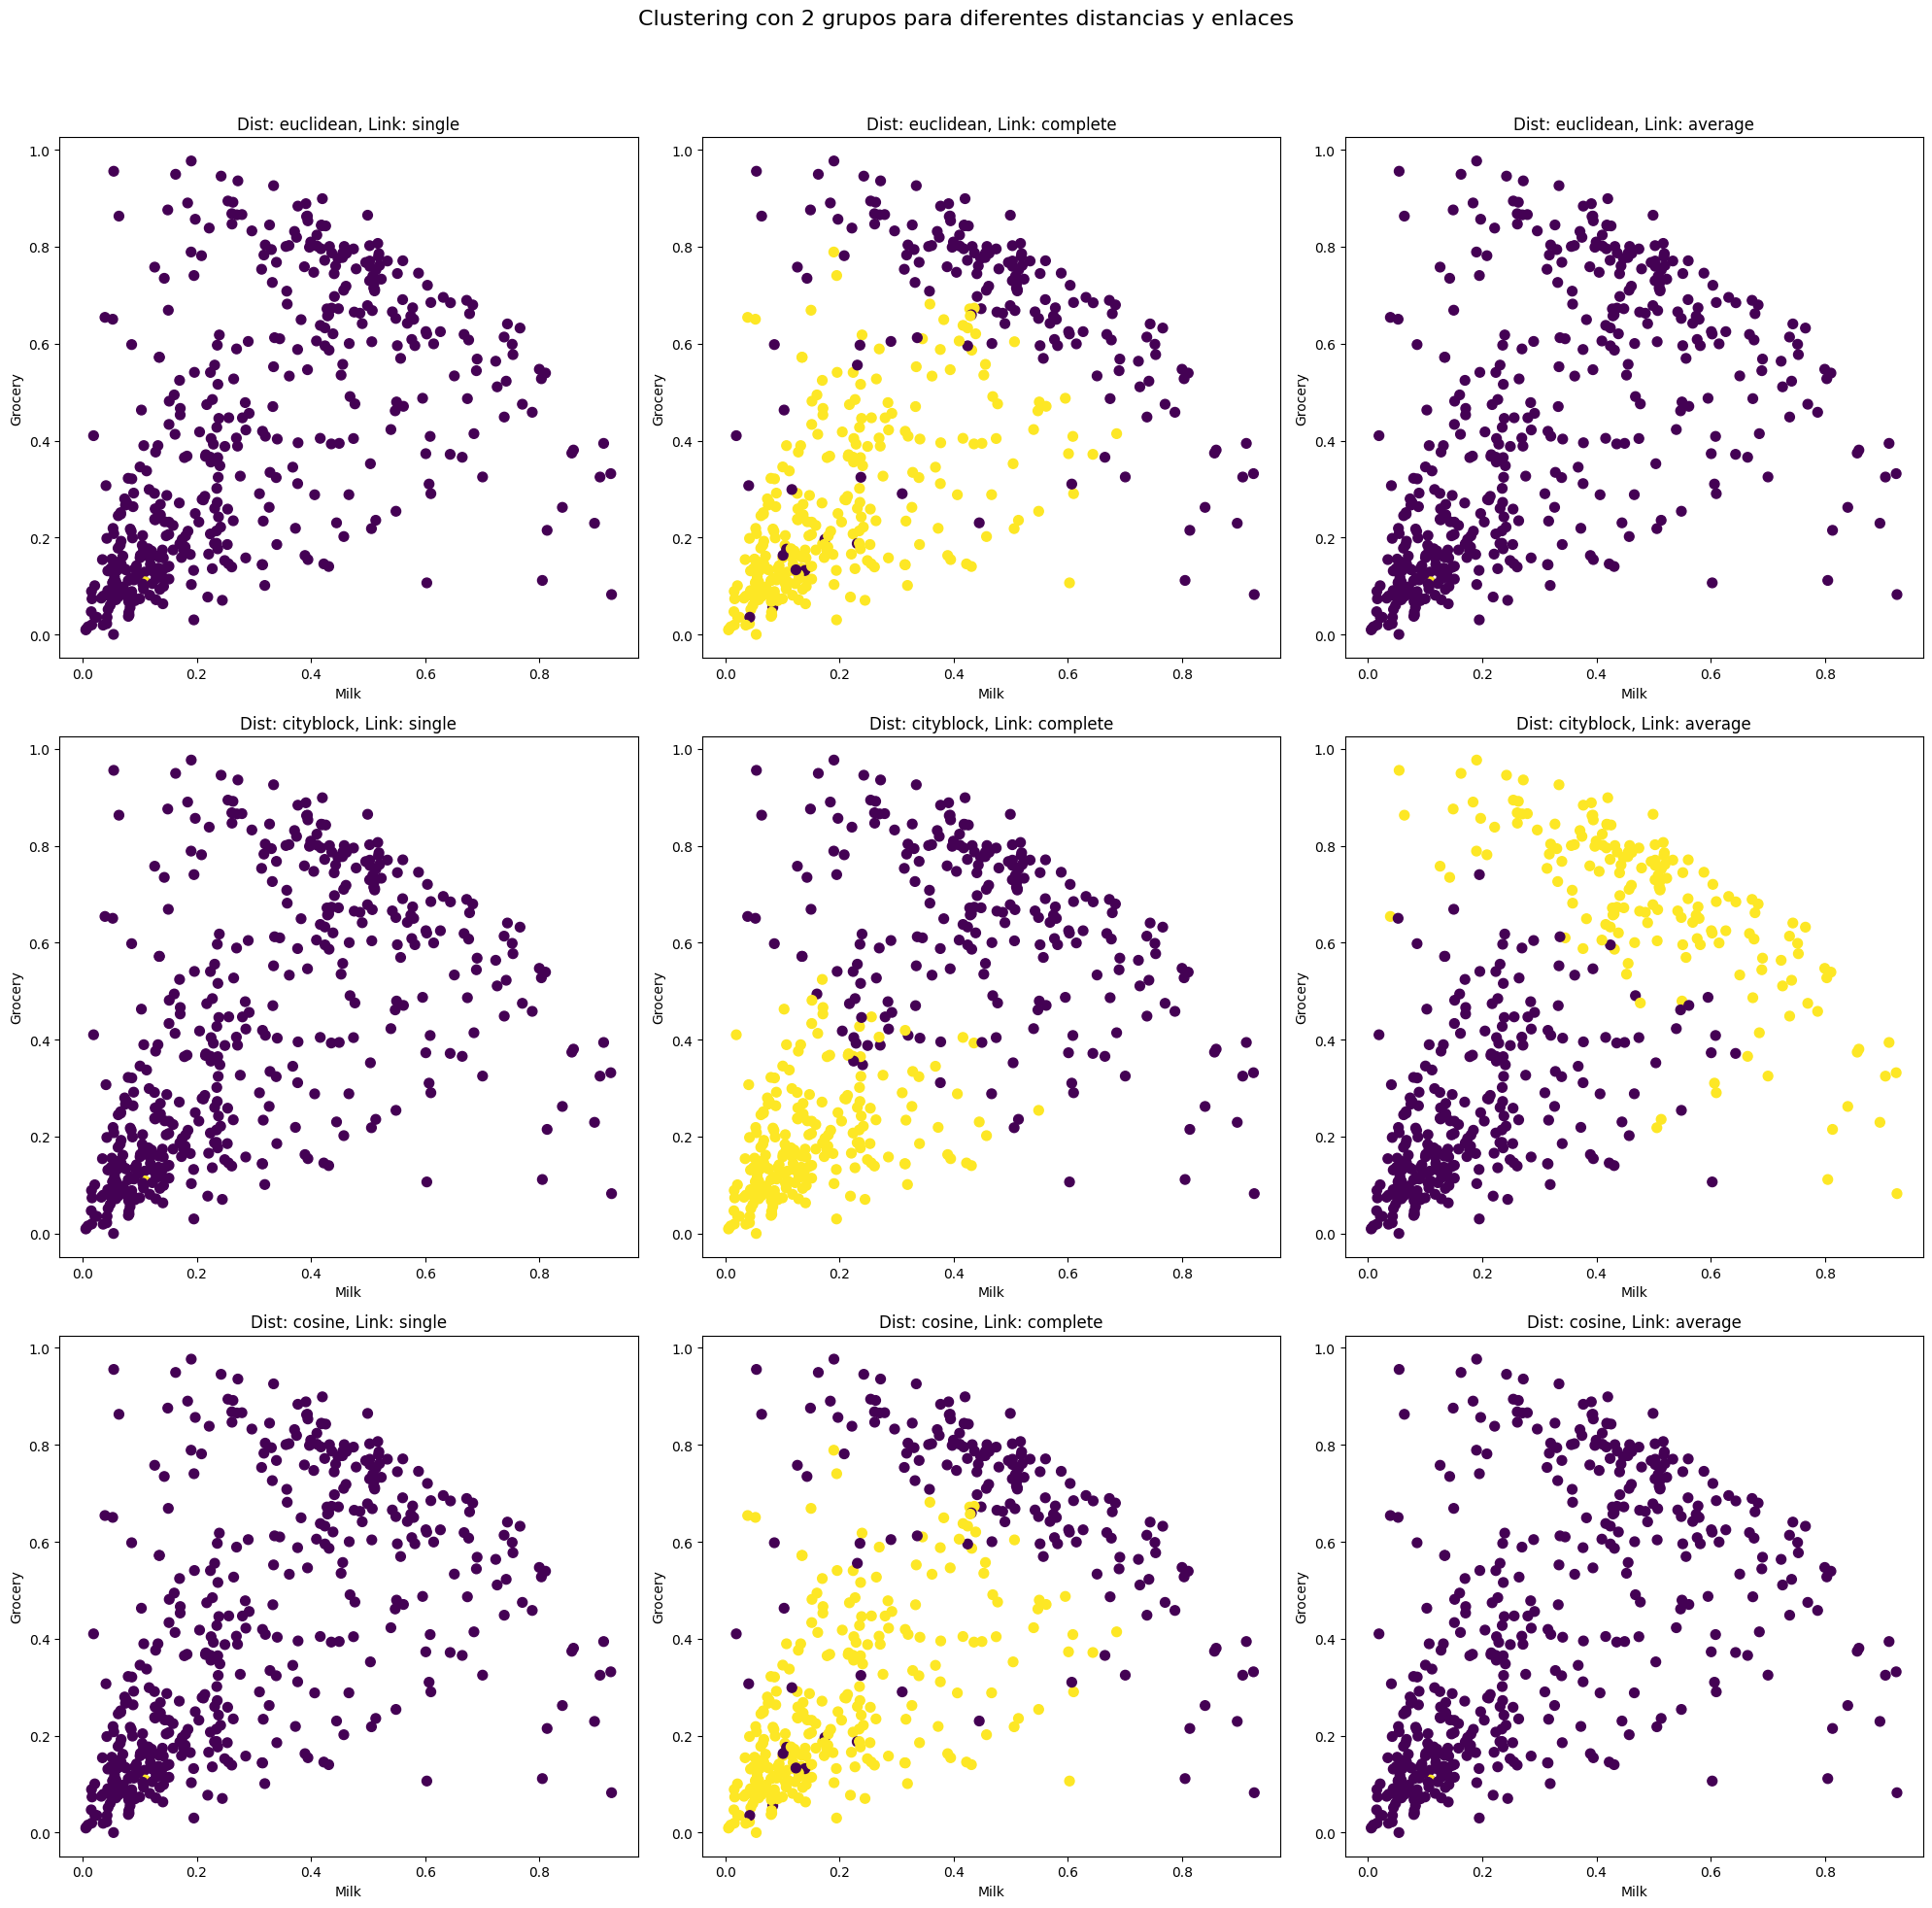

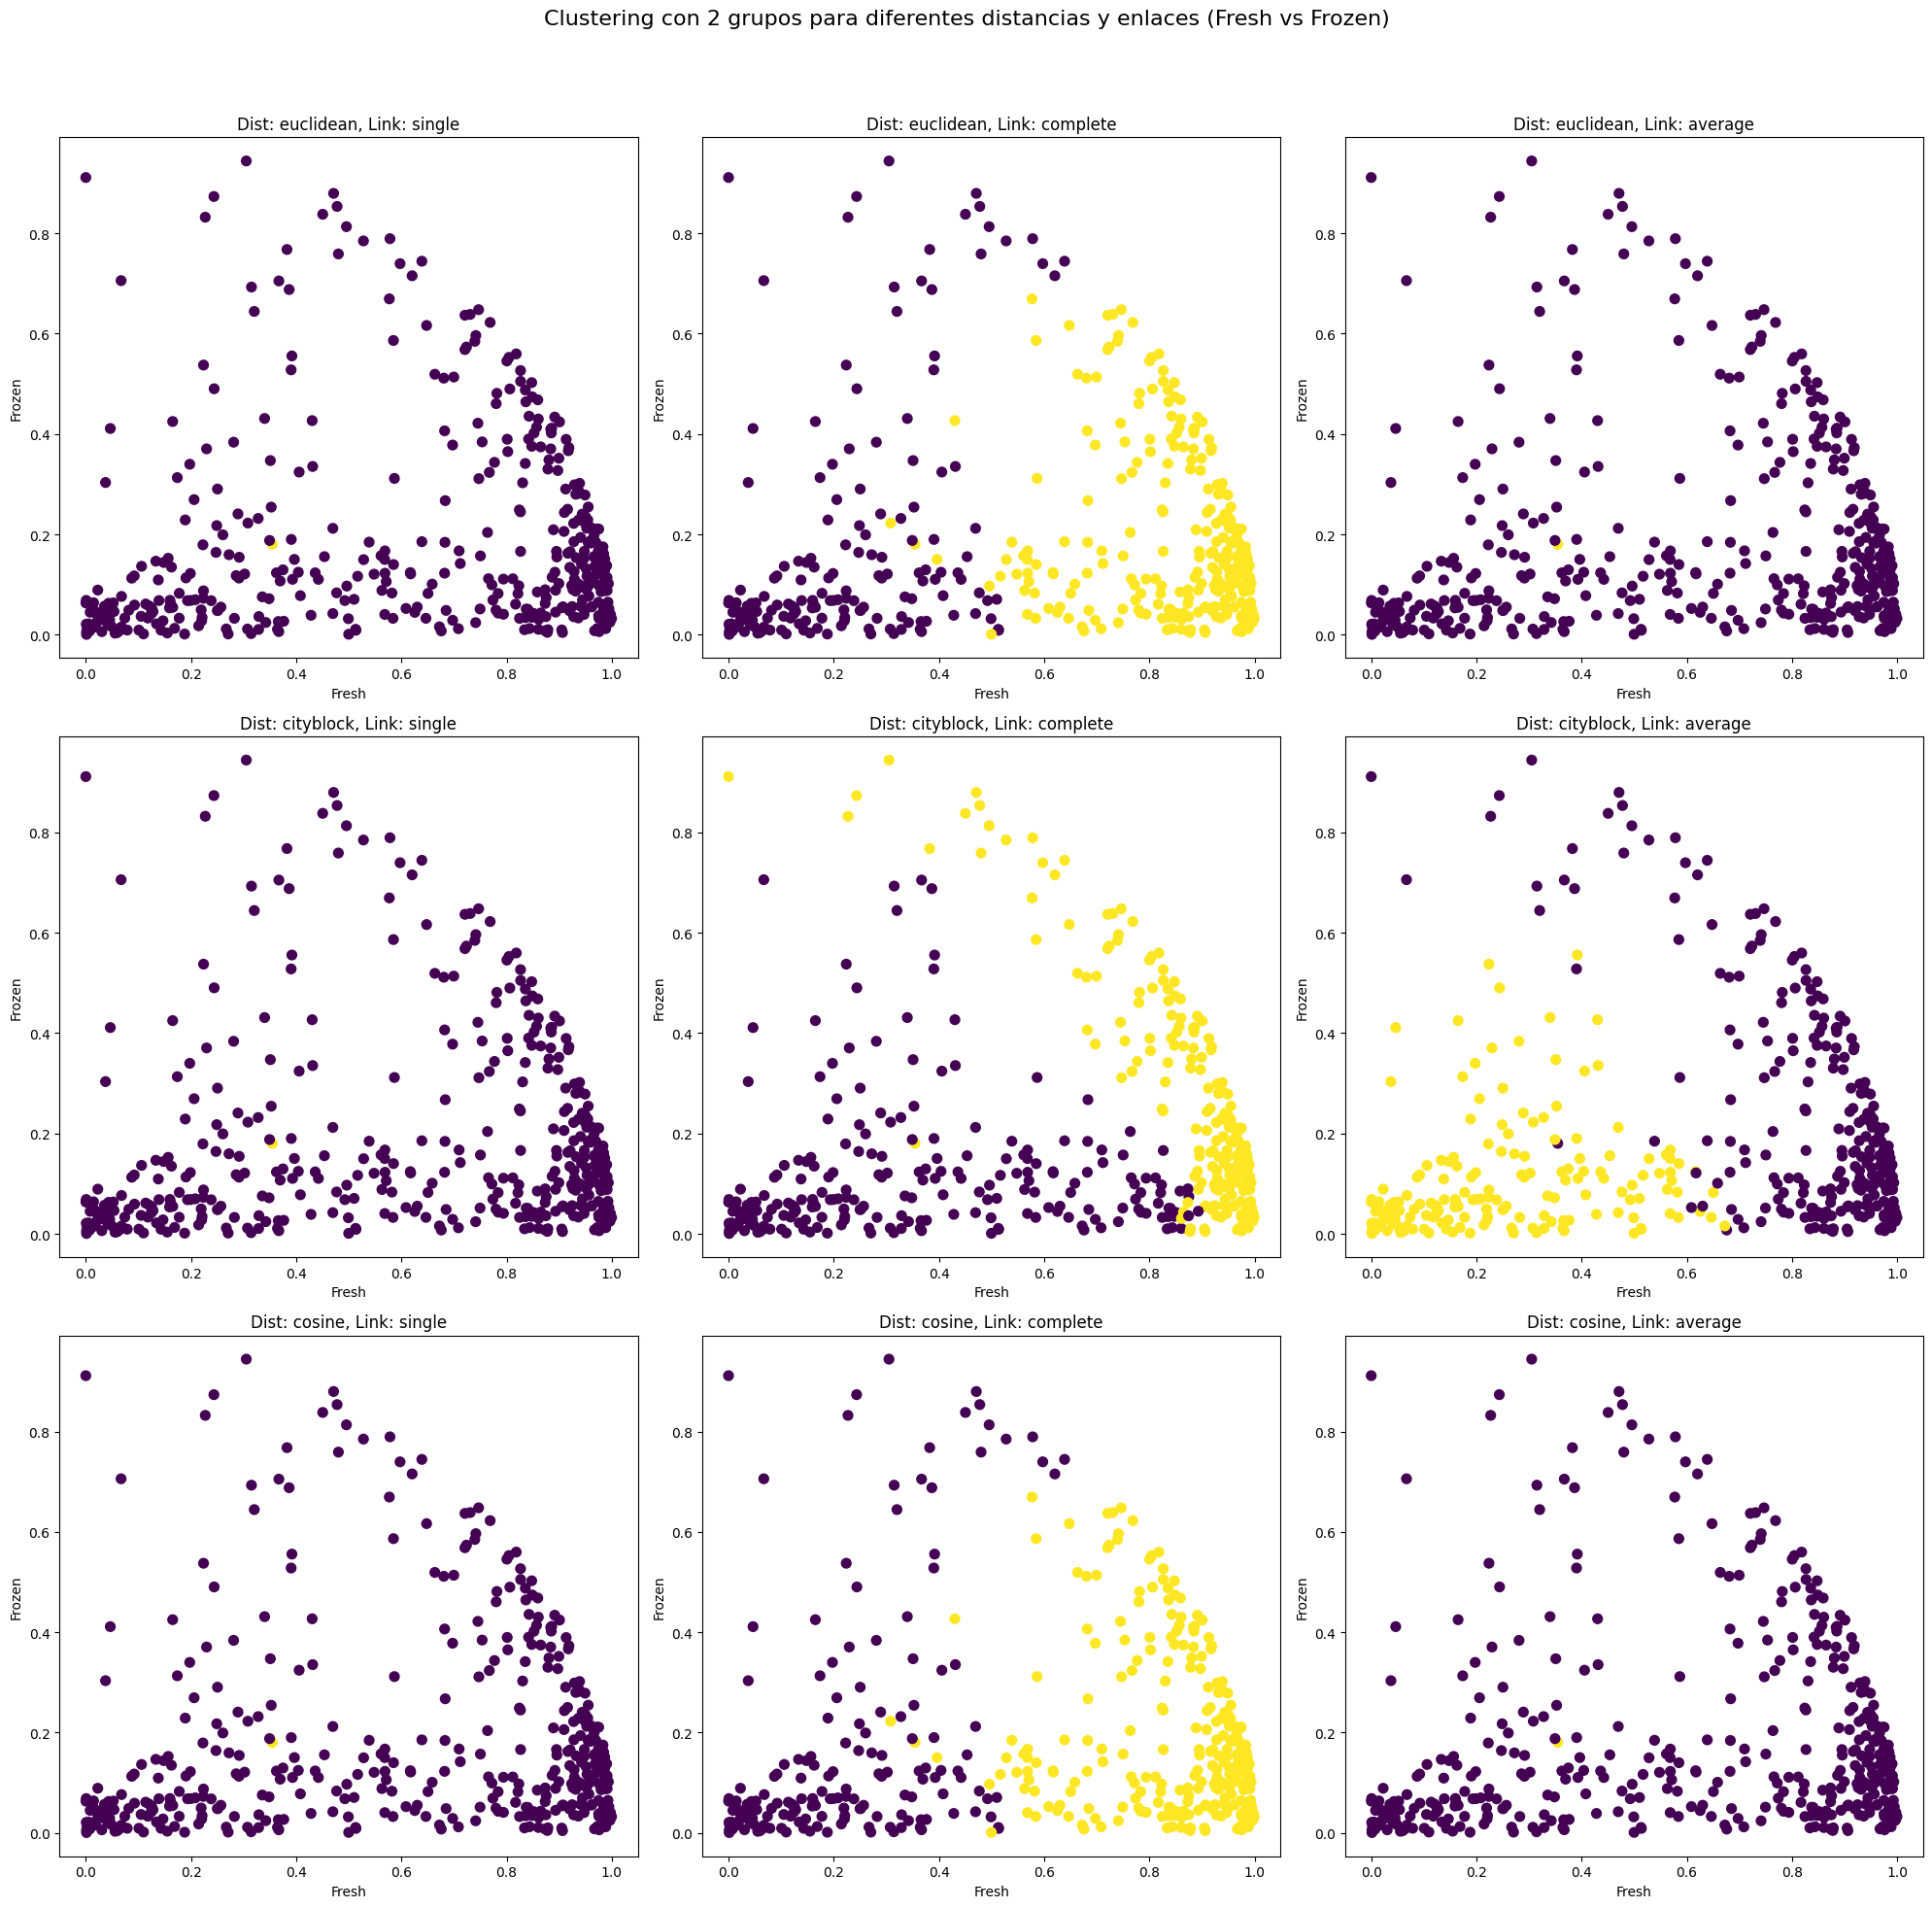

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering


data = pd.read_csv('Wholesale customers data.csv')

data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# Distancias y tipos de enlace
distances = ['euclidean', 'cityblock', 'cosine']  # cityblock es Manhattan
linkages = ['single', 'complete', 'average']

fig, axs = plt.subplots(len(distances), len(linkages), figsize=(20, 20))
fig.suptitle('Dendrogramas con diferentes combinaciones de distancia y enlace', fontsize=16)

for i, dist in enumerate(distances):
    for j, link in enumerate(linkages):
        axs[i, j].set_title(f'Dist: {dist}, Link: {link}')
        dend = shc.dendrogram(shc.linkage(data_scaled, method=link, metric=dist), ax=axs[i, j])
        axs[i, j].set_xlabel('Clientes')
        axs[i, j].set_ylabel(f'Distancia {dist.capitalize()}')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Visualización de clusters (2 grupos)
fig, axs = plt.subplots(len(distances), len(linkages), figsize=(20, 20))
fig.suptitle('Clustering con 2 grupos para diferentes distancias y enlaces', fontsize=16)

for i, dist in enumerate(distances):
    for j, link in enumerate(linkages):
        if dist == 'cityblock':
            metric_name = 'manhattan'  # nombre de la métrica que usa AgglomerativeClustering
        else:
            metric_name = dist

        # AgglomerativeClustering para 2 grupos
        ac = AgglomerativeClustering(n_clusters=2, metric=metric_name, linkage=link)
        y_hat = ac.fit_predict(data_scaled)

        axs[i, j].scatter(data_scaled['Milk'], data_scaled['Grocery'], c=y_hat, s=50, cmap='viridis')
        axs[i, j].set_title(f'Dist: {dist}, Link: {link}')
        axs[i, j].set_xlabel('Milk')
        axs[i, j].set_ylabel('Grocery')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axs = plt.subplots(len(distances), len(linkages), figsize=(20, 20))
fig.suptitle('Clustering con 2 grupos para diferentes distancias y enlaces (Fresh vs Frozen)', fontsize=16)

for i, dist in enumerate(distances):
    for j, link in enumerate(linkages):
        if dist == 'cityblock':
            metric_name = 'manhattan'  # nombre de la métrica que usa AgglomerativeClustering
        else:
            metric_name = dist
        # Aplicar AgglomerativeClustering para 2 grupos
        ac = AgglomerativeClustering(n_clusters=2, metric=metric_name, linkage=link)
        y_hat = ac.fit_predict(data_scaled)

        axs[i, j].scatter(data_scaled['Fresh'], data_scaled['Frozen'], c=y_hat, s=50, cmap='viridis')
        axs[i, j].set_title(f'Dist: {dist}, Link: {link}')
        axs[i, j].set_xlabel('Fresh')
        axs[i, j].set_ylabel('Frozen')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Dendrogramas**:
- **Euclidean Distance**:
  - **Single linkage**: Tiende a producir clusters más largos y dispersos, lo que puede dar lugar a agrupaciones menos compactas. Los objetos se agrupan uno a uno, formando una cadena.
  - **Complete linkage**: Produce clusters más compactos, donde el criterio de agrupamiento se basa en las distancias máximas entre los puntos de diferentes clusters.
  - **Average linkage**: Logra un equilibrio entre la compactación de los clusters y su dispersión.

- **Manhattan Distance (Cityblock)**:
  - Similar comportamiento al Euclidean, pero la forma en que mide la distancia difiere, ya que suma las diferencias absolutas en cada dimensión en lugar de utilizar la distancia directa. Esto tiende a producir clusters ligeramente diferentes, sobre todo cuando los puntos están más dispersos.
  - El **single linkage** con Manhattan a menudo puede producir más "cadenas" de puntos que el Euclidean, ya que el cálculo de la distancia es diferente.
  - **Complete** y **Average** también se comportan de manera similar, pero con pequeñas variaciones en la formación de clusters.

- **Cosine Distance**:
  - El criterio de agrupamiento está basado en la similitud de los ángulos entre los puntos en lugar de la distancia física. Esto puede resultar en clusters que capturan relaciones angulares más que distancias absolutas.
  - **Single linkage**, los clusters pueden ser menos interpretables debido a la naturaleza de la distancia Cosine, que agrupa puntos con base en la dirección en lugar de la magnitud.
  - **Complete** y **average**: Los clusters son menos compactos que con las distancias Euclidean o Manhattan, especialmente cuando los puntos son muy diferentes en términos de magnitud, pero similares en dirección.

**Clustering con 2 Grupos**:
- **Euclidean Distance**:
  - Clusters relativamente compactos, especialmente con el método **complete**. Se observa una clara división entre dos grupos en las gráficas de dispersión.
  - En el **single linkage**, es posible que algunos puntos estén más alejados del grupo principal, debido a la naturaleza dispersa de este método.

- **Manhattan Distance (Cityblock)**:
  - Similar al Euclidean, pero los clusters pueden estar más alargados y, en algunos casos, los límites entre grupos pueden ser más difusos, especialmente con **single linkage**.
  - **Complete** y **average** muestran agrupaciones más coherentes, con límites más claros entre los grupos.

- **Cosine Distance**:
  - Los clusters basados en similitud angular pueden ser menos intuitivos de interpretar, ya que los puntos que parecen alejados en términos de magnitud pueden terminar en el mismo cluster.
  - El **complete linkage** suele dar mejores resultados con Cosine, produciendo agrupaciones más coherentes en términos de similitud direccional.

## Ejemplo 2

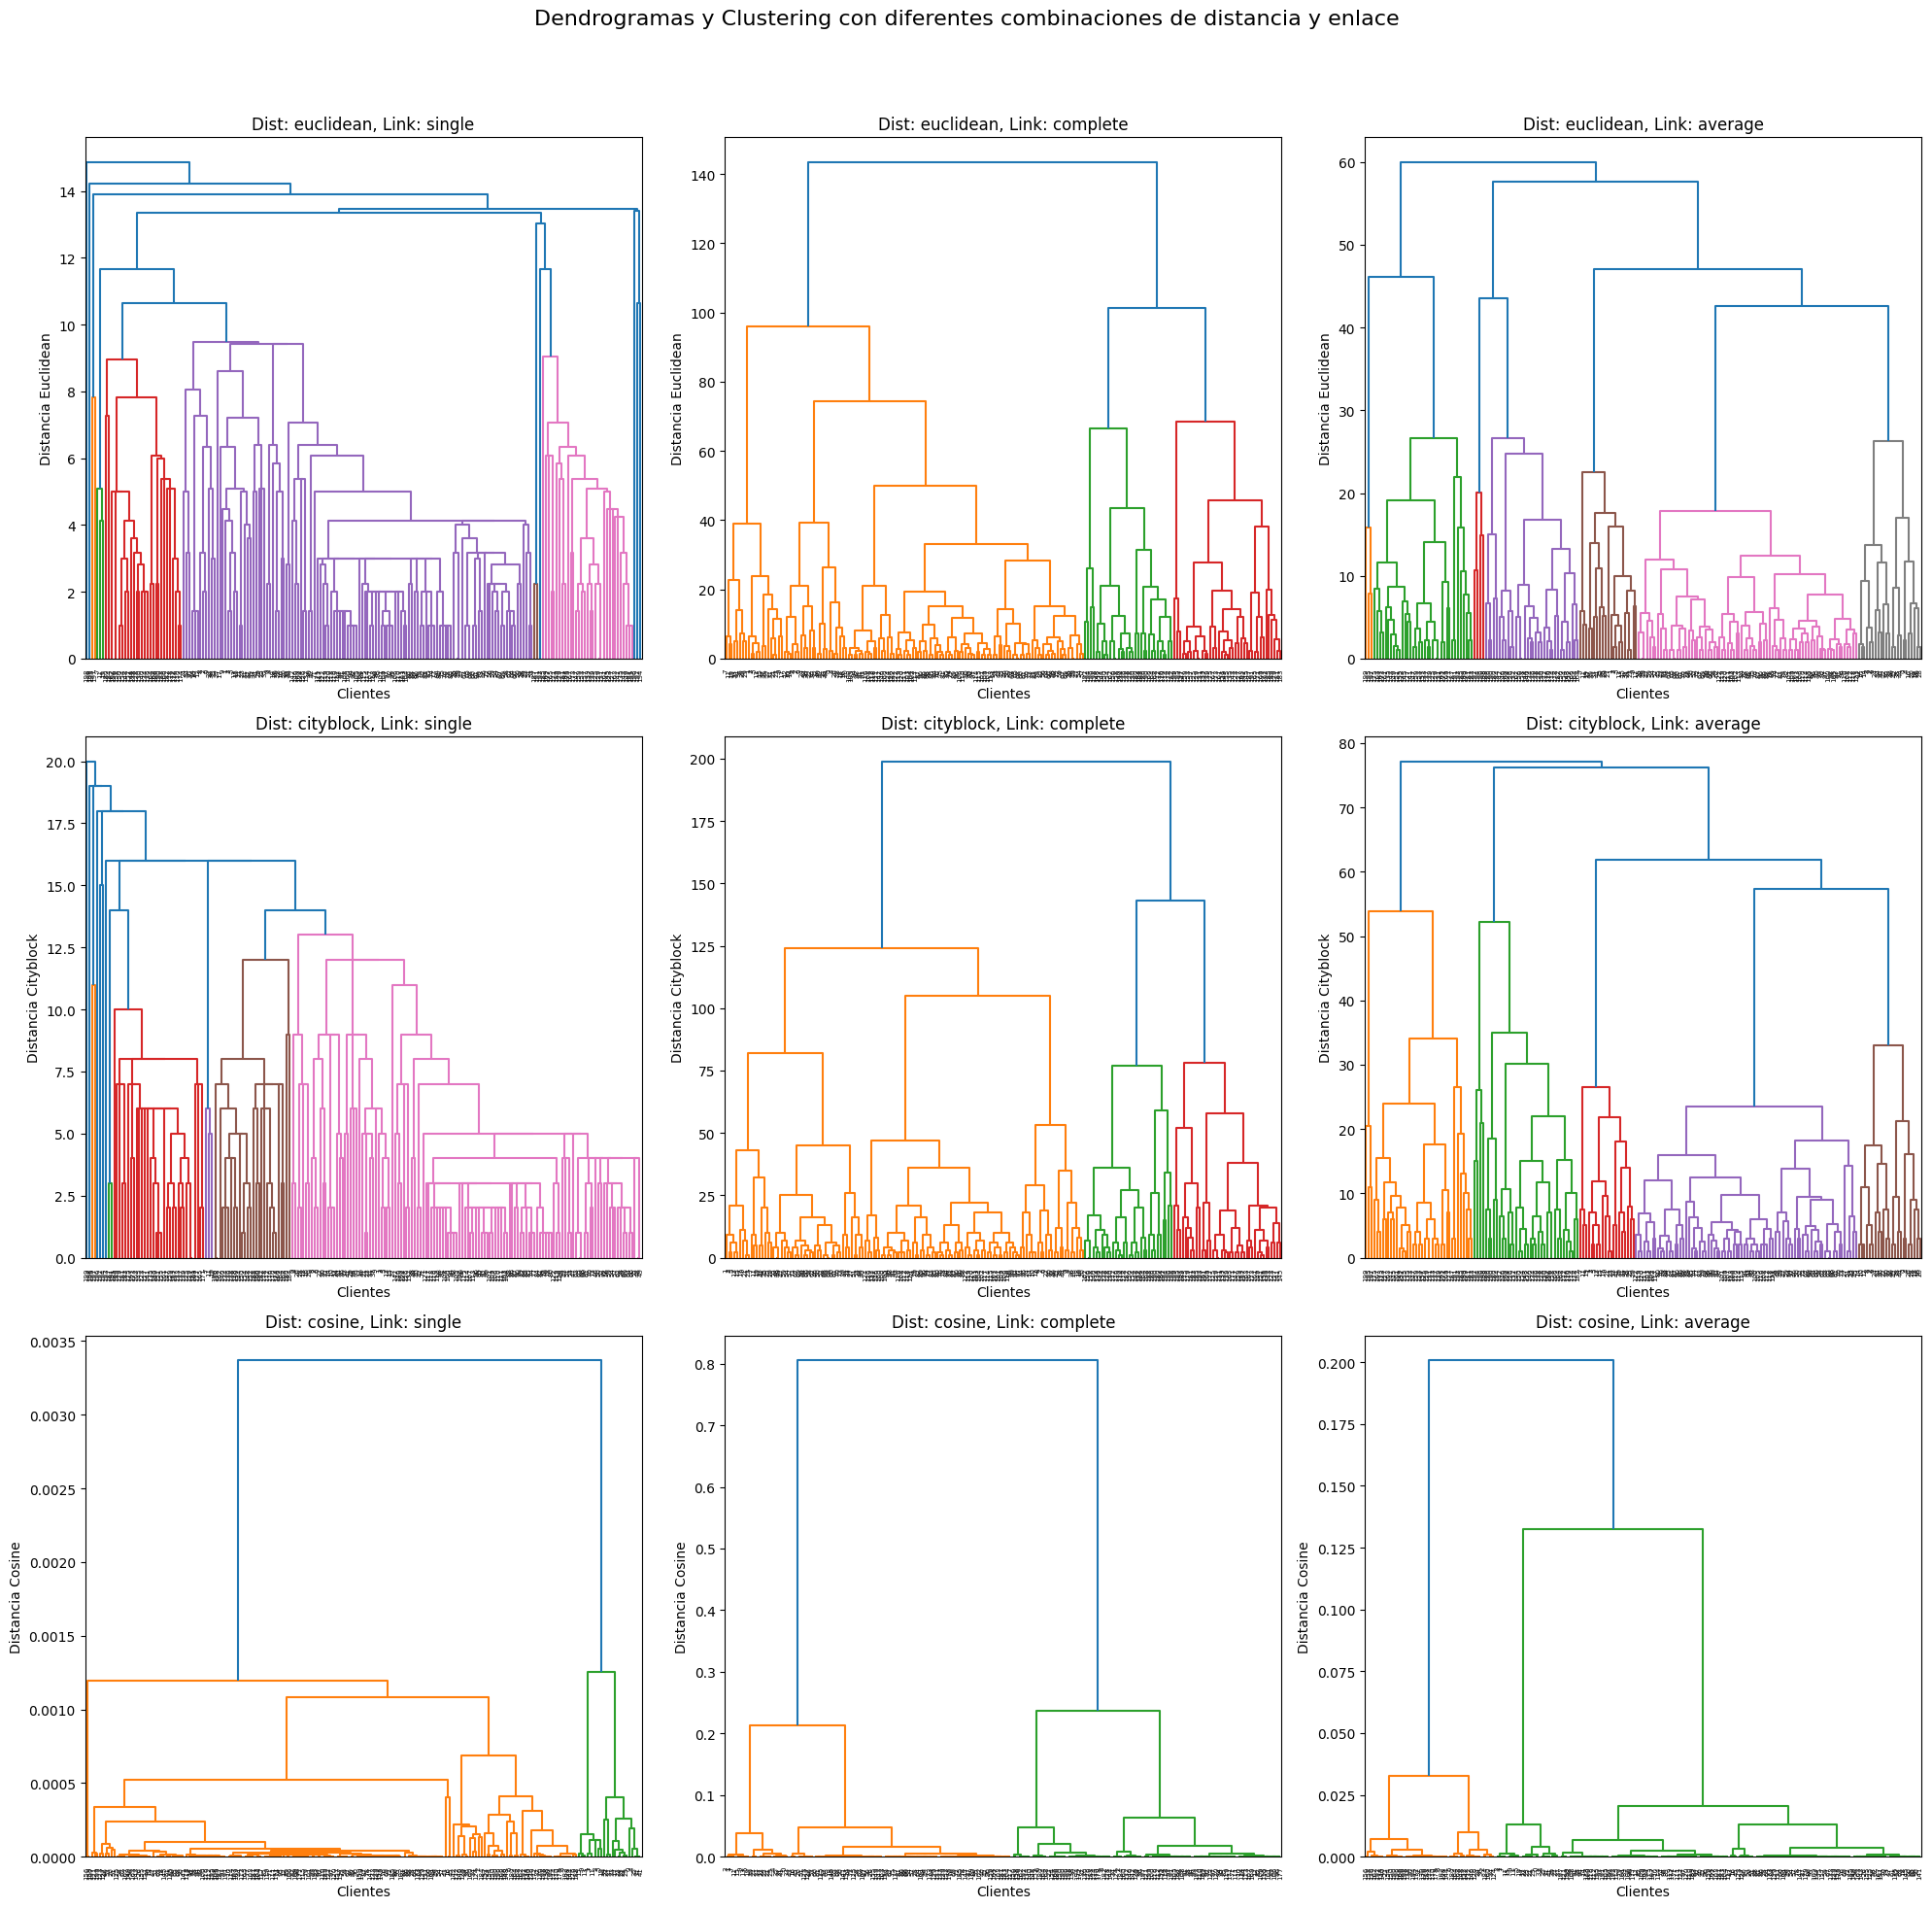

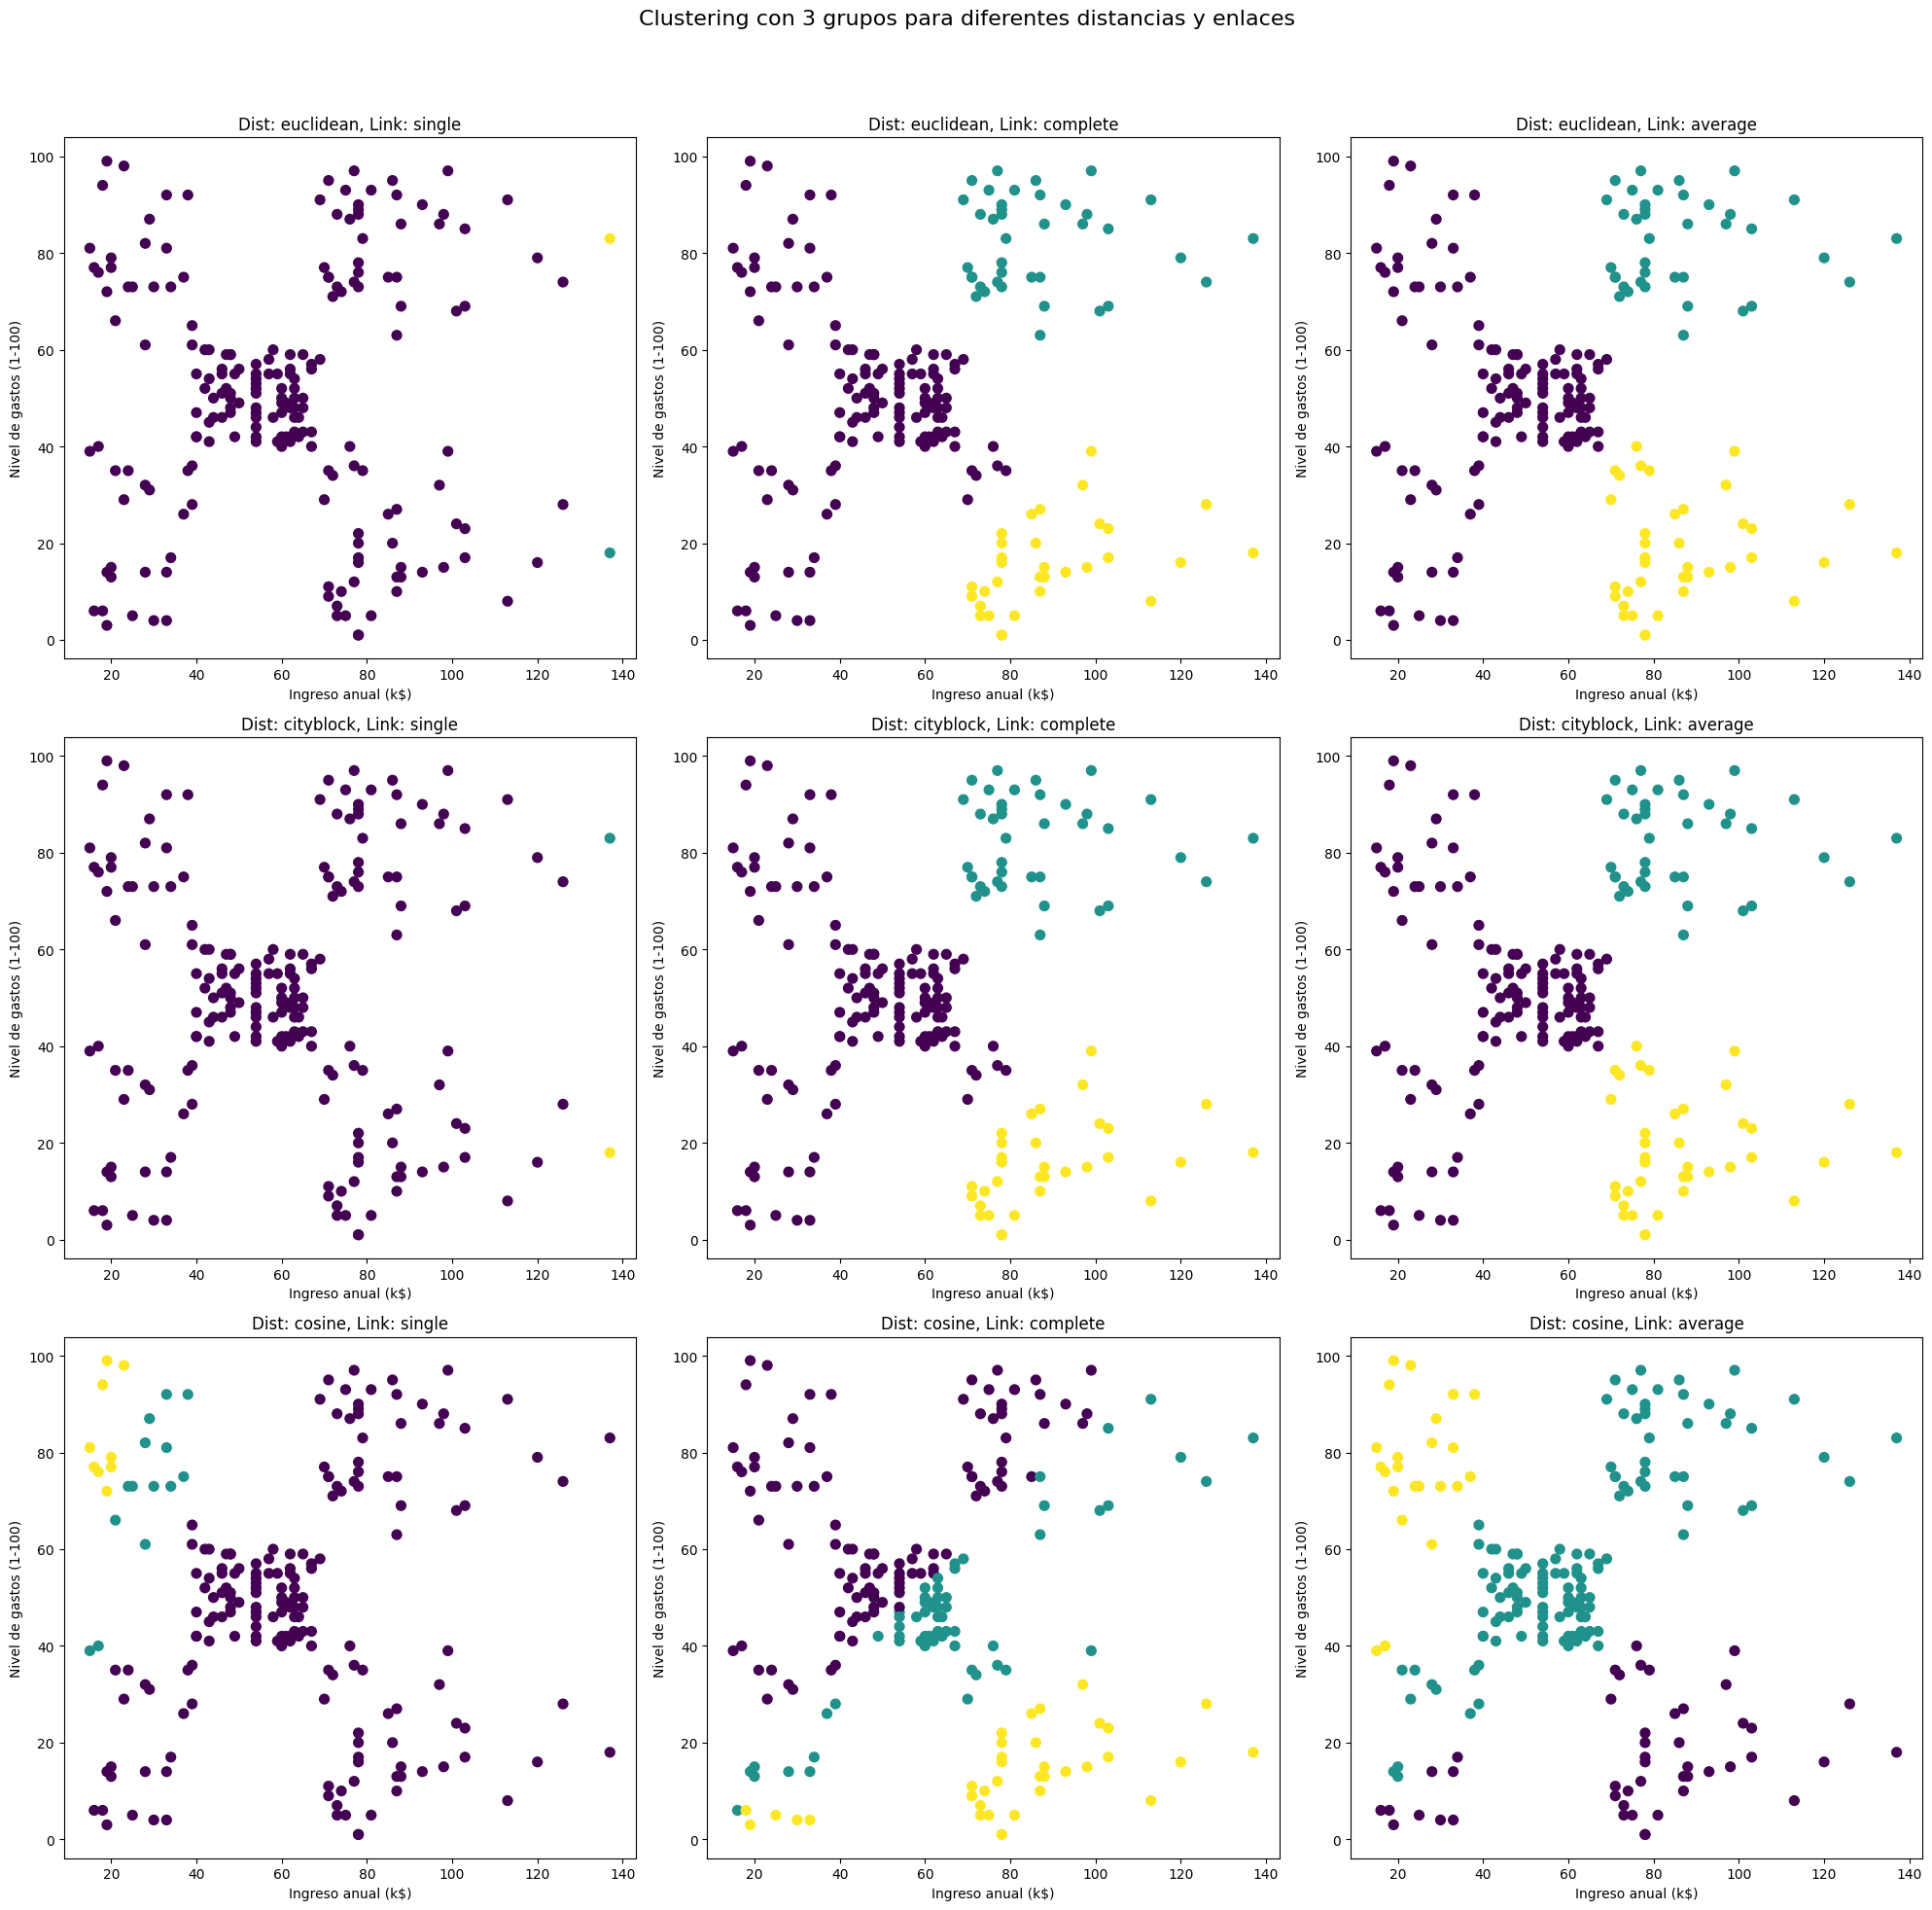

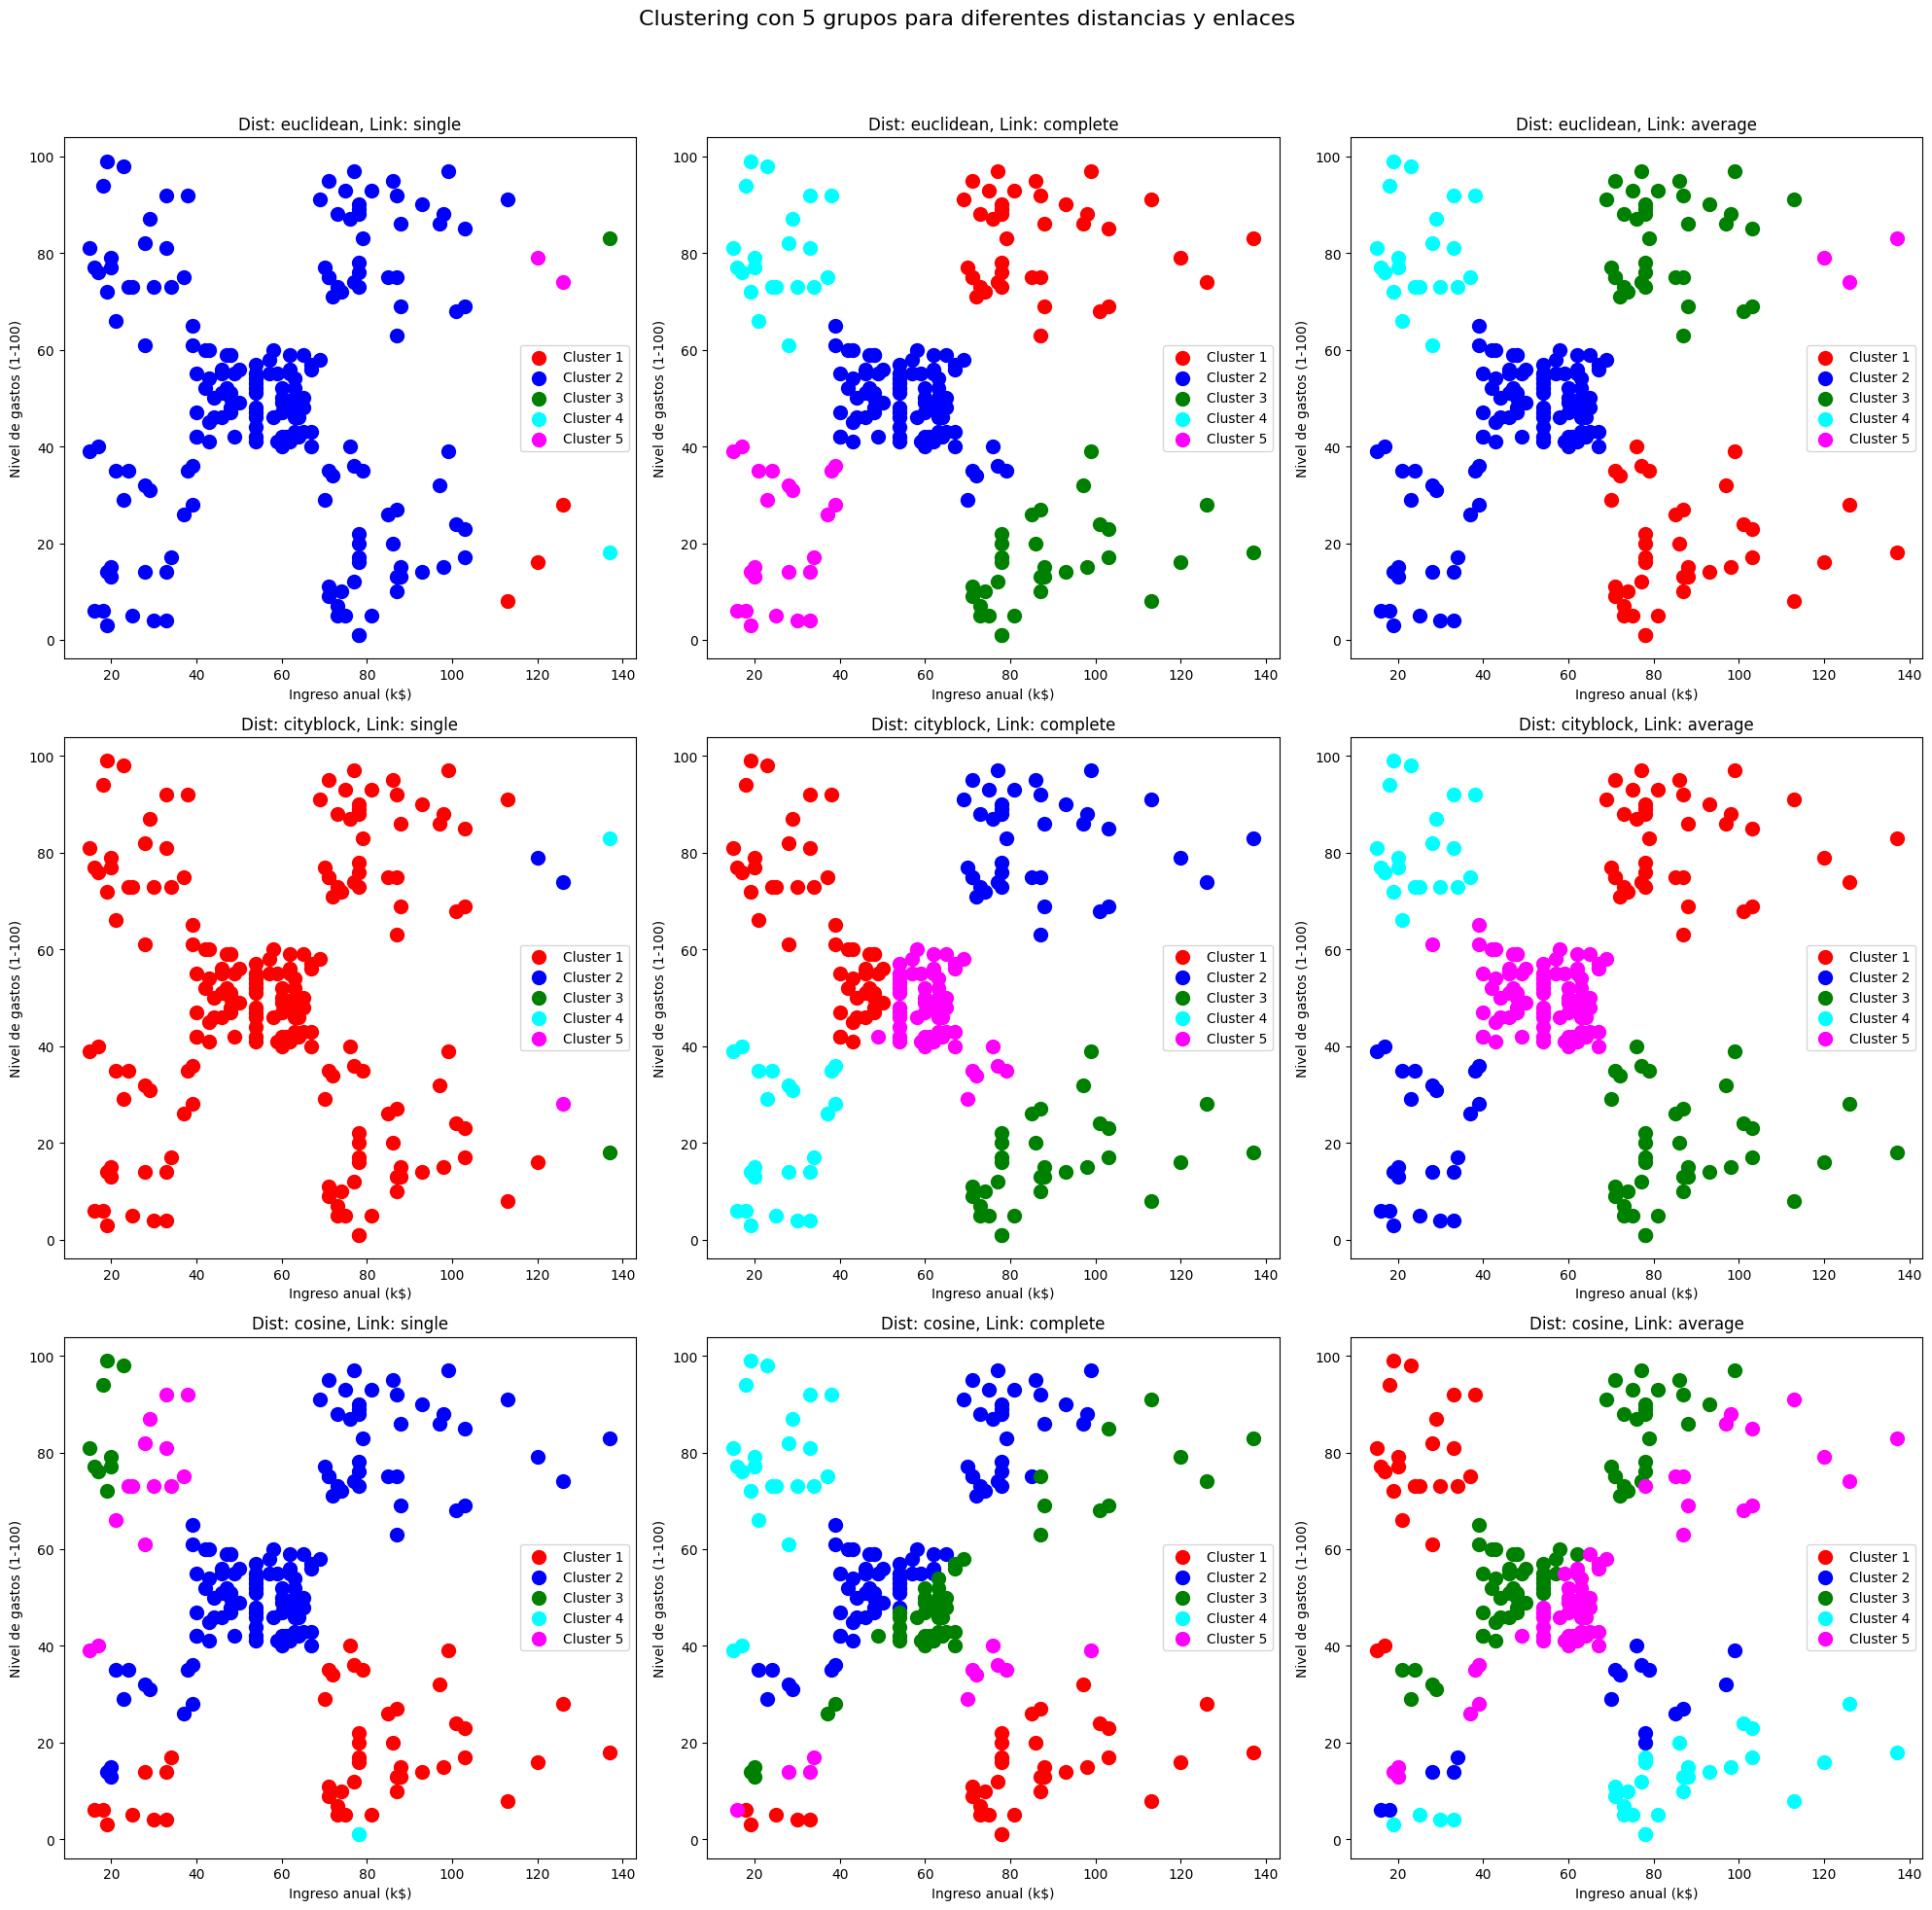

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

dataset = pd.read_csv('https://bit.ly/3TUeh37')

# Columnas de interés
X = dataset.iloc[:, [3, 4]].values

distances = ['euclidean', 'cityblock', 'cosine']  # cityblock es Manhattan
linkages = ['single', 'complete', 'average']

fig, axs = plt.subplots(len(distances), len(linkages), figsize=(20, 20))
fig.suptitle('Dendrogramas y Clustering con diferentes combinaciones de distancia y enlace', fontsize=16)

for i, dist in enumerate(distances):
    for j, link in enumerate(linkages):
        axs[i, j].set_title(f'Dist: {dist}, Link: {link}')
        dend = shc.dendrogram(shc.linkage(X, method=link, metric=dist), ax=axs[i, j])
        axs[i, j].set_xlabel('Clientes')
        axs[i, j].set_ylabel(f'Distancia {dist.capitalize()}')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Visualización de 3 grupos
fig, axs = plt.subplots(len(distances), len(linkages), figsize=(20, 20))
fig.suptitle('Clustering con 3 grupos para diferentes distancias y enlaces', fontsize=16)

for i, dist in enumerate(distances):
    for j, link in enumerate(linkages):
        # Aplicar AgglomerativeClustering para 3 grupos
        if dist == 'cityblock':
            metric_name = 'manhattan'  # nombre de la métrica que usa AgglomerativeClustering
        else:
            metric_name = dist

        ac = AgglomerativeClustering(n_clusters=3, metric=metric_name, linkage=link)
        y_hat = ac.fit_predict(X)

        axs[i, j].scatter(X[:, 0], X[:, 1], c=y_hat, s=50, cmap='viridis')
        axs[i, j].set_title(f'Dist: {dist}, Link: {link}')
        axs[i, j].set_xlabel('Ingreso anual (k$)')
        axs[i, j].set_ylabel('Nivel de gastos (1-100)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Visualización de 5 grupos
fig, axs = plt.subplots(len(distances), len(linkages), figsize=(20, 20))
fig.suptitle('Clustering con 5 grupos para diferentes distancias y enlaces', fontsize=16)

for i, dist in enumerate(distances):
    for j, link in enumerate(linkages):
        # Aplicar AgglomerativeClustering para 5 grupos
        if dist == 'cityblock':
            metric_name = 'manhattan'  # nombre de la métrica que usa AgglomerativeClustering
        else:
            metric_name = dist

        ac = AgglomerativeClustering(n_clusters=5, metric=metric_name, linkage=link)
        y_hc = ac.fit_predict(X)

        # Graficar clusters con 5 grupos
        axs[i, j].scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s=100, c='red', label='Cluster 1')
        axs[i, j].scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s=100, c='blue', label='Cluster 2')
        axs[i, j].scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s=100, c='green', label='Cluster 3')
        axs[i, j].scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s=100, c='cyan', label='Cluster 4')
        axs[i, j].scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s=100, c='magenta', label='Cluster 5')
        axs[i, j].set_title(f'Dist: {dist}, Link: {link}')
        axs[i, j].set_xlabel('Ingreso anual (k$)')
        axs[i, j].set_ylabel('Nivel de gastos (1-100)')
        axs[i, j].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Dendrogramas**:
- **Euclidean Distance**:
  - **Single linkage**: Como en el primer ejemplo, este método tiende a formar clusters en forma de cadena, es decir, objetos que están muy cercanos entre sí van siendo agrupados uno a uno. 
  - **Complete linkage**: Proporciona clusters más compactos, ya que minimiza la distancia máxima entre puntos en clusters diferentes. 
  - **Average linkage**: Ofrece un agrupamiento más balanceado, con clusters que no son ni muy dispersos ni extremadamente compactos.

- **Manhattan Distance (Cityblock)**:
  - El comportamiento es similar al Euclidean, pero como la distancia se mide en términos de la suma de las diferencias absolutas en cada dimensión, los clusters pueden estar un poco más alargados. En el **single linkage**, esto puede llevar a resultados donde los puntos más cercanos en términos de distancia Manhattan son agrupados primero, creando cadenas alargadas.
  - **Complete linkage** produce agrupaciones más compactas en comparación con **single**, y **average** ofrece una alternativa intermedia, proporcionando clusters razonablemente coherentes.

- **Cosine Distance**:
  - En los dendrogramas basados en la distancia Cosine, la agrupación se basa en la similitud angular entre los puntos, no en su magnitud. Esto puede llevar a clusters que agrupen puntos que parecen lejanos en términos de distancia, pero que tienen una dirección similar.
  - El **single linkage** con Cosine puede producir agrupaciones donde los puntos se conectan en "cadenas" basadas en su similitud angular. **Complete** y **average** ofrecen agrupamientos más coherentes, con **complete linkage** tendiendo a proporcionar clusters más compactos que los otros métodos.

**Clustering con 3 Grupos**:
- **Euclidean Distance**:
  - Con **complete linkage**, los clusters se ven compactos y bien diferenciados. Los puntos dentro de cada cluster están cercanos entre sí, y las fronteras entre los clusters están bastante claras.
  - **Single linkage** agrupa puntos que están muy cercanos en distancia Euclidean, pero en algunos casos esto puede resultar en clusters que se extienden más de lo esperado, lo que hace que la separación entre los grupos no sea tan clara.
  - **Average linkage** proporciona resultados más balanceados, con clusters que tienen una forma más intermedia en cuanto a dispersión y compactación.

- **Manhattan Distance**:
  - Similar al Euclidean, pero los clusters tienden a ser más alargados en algunas direcciones, lo que puede hacer que algunos puntos dentro de los clusters estén un poco más dispersos.
  - **Complete linkage** con Manhattan sigue proporcionando clusters compactos, mientras que **single linkage** a veces puede generar agrupaciones menos claras, especialmente cuando los puntos están más dispersos en el espacio.

- **Cosine Distance**:
  - Con Cosine, los puntos que están en la misma dirección pero a diferentes magnitudes pueden terminar en el mismo cluster. Esto puede ser útil cuando los datos tienen alguna relación angular, pero en datos numéricos como los que estamos usando, puede producir clusters que no son tan intuitivos visualmente.
  - **Complete linkage** funciona mejor con Cosine, ya que tiende a producir clusters más coherentes, mientras que **single linkage** puede generar resultados más dispersos.

**Clustering con 5 Grupos**:
- **Euclidean Distance**:
  - **Complete linkage** tiende a producir clusters bien separados y compactos, especialmente en los conjuntos de datos donde los puntos están claramente diferenciados en términos de magnitud.
  - **Single linkage** puede generar clusters más alargados y menos compactos, donde algunos puntos están más alejados de los centros de los clusters, pero aún se agrupan debido a su proximidad a otros puntos.
  - **Average linkage** sigue proporcionando un buen equilibrio, produciendo clusters que no son ni demasiado dispersos ni demasiado compactos.

- **Manhattan Distance**:
  - Similar al Euclidean, pero como antes, los clusters tienden a estar más alargados. **Complete linkage** sigue proporcionando la mayor compactación de clusters, mientras que **single linkage** puede ser menos efectivo al agrupar puntos dispersos.

- **Cosine Distance**:
  - Los clusters formados con Cosine pueden ser menos intuitivos en términos de la magnitud de los puntos, pero capturan bien las relaciones direccionales. Esto es particularmente evidente en los clusters formados con **average** y **complete linkage**.
  - **Single linkage** puede producir agrupaciones menos coherentes, donde los puntos pueden parecer menos relacionados en términos de distancia física.